In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.widgets as widgets
import matplotlib.colors as colors
import matplotlib as mpl

import matplotlib.gridspec as gridspec

import shapefile # pyshp library
from descartes import PolygonPatch

from bs4 import BeautifulSoup

%matplotlib notebook

In [2]:
regeng = ['Kazakhstan',
          'Akmola Region', 
          'Aktobe Region', 
          'Almaty Region', 
          'Atyrau Region', 
          'West Kazakhstan Region',
          'Jambyl Region',
          'Karaganda Region',
          'Kostanay Region',
          'Kyzylorda Region',
          'Mangystau Region',
          'South Kazakhstan Region',
          'Pavlodar Region',
          'North Kazakhstan Region',
          'East Kazakhstan Region',
          'Astana',
          'Almaty']
regdict = {'Almaty': 'Almaty Region',
           'Aqmola': 'Akmola Region',
           'Aqtöbe': 'Aktobe Region',
           'Atyrau': 'Atyrau Region',
           'East Kazakhstan': 'East Kazakhstan Region',
           'Mangghystau': 'Mangystau Region',
           'North Kazakhstan': 'North Kazakhstan Region',
           'Pavlodar': 'Pavlodar Region',
           'Qaraghandy': 'Karaganda Region',
           'Qostanay': 'Kostanay Region',
           'Qyzylorda': 'Kyzylorda Region',
           'South Kazakhstan': 'South Kazakhstan Region',
           'West Kazakhstan': 'West Kazakhstan Region',
           'Zhambyl': 'Jambyl Region'}

In [3]:
# This is official data from Kazakhstan Bureau of Statistics
df = pd.read_excel('data/kz-demographics-2004-2015.xlsx', skiprows=2)

In [4]:
# Reading map data, naming regions properly

shpFilePath = "data/KAZ_adm1.shp"  
sf  = shapefile.Reader(shpFilePath)
shapes = sf.shapes()
shapeRecs = sf.shapeRecords()

for shapeRec in shapeRecs:
    shapeRec.record[4] = regdict[shapeRec.record[4]]

In [5]:
# Preparing data for plotting
# RNI — rate of natural increase, the difference between crude_birth_rate and crude_death_rate

crude_birth_rate = df.iloc[18:35]
crude_mort_rate = df.iloc[57:74]
RNI = df.iloc[96:]

crude_birth_rate = crude_birth_rate.rename(columns={'Unnamed: 0': 'Regions'})
crude_mort_rate = crude_mort_rate.rename(columns={'Unnamed: 0': 'Regions'})
RNI = RNI.rename(columns={'Unnamed: 0': 'Regions'})

d = crude_birth_rate['Regions']
regions = {k:v for k,v in zip(d, regeng)}

crude_birth_rate.replace(to_replace={'Regions': regions}, inplace=True)
crude_mort_rate.replace({'Regions': regions}, inplace=True)
RNI.replace({'Regions': regions}, inplace=True)

crude_birth_rate.set_index('Regions', drop=True, inplace=True)
crude_mort_rate.set_index('Regions', drop=True, inplace=True)
RNI.set_index('Regions', drop=True, inplace=True)

In [6]:
# Data prior to 2004 is from different tables

def get_early_records(filename, c1, c2):
    html_doc = open(filename)
    soup = BeautifulSoup(html_doc, 'html.parser')
    
    table = soup.find("table")
    rows = table.findAll('tr')
    rows = rows[4:21]
    
    col1 = []
    col2 = []
    for row in rows:
        cells = row.findAll('td')
        col1.append(cells[c1].find(text=True))
        col2.append(cells[c2].find(text=True))
    
    col1float = [float(x.replace(',', '.')) for x in col1]
    col2float = [float(x.replace(',', '.')) for x in col2]
    
    return col1float, col2float

# CRUDE BIRTH RATE: c1=3 c2=4
# CRUDE MORTALITY RATE: c1=5, c2=6
# RATE OF NATURAL INCREASE: c1=1, c2=2
# For 2000-2001, c1 -> 2001, c2 -> 2000
# For 2002-2003, c1 -> 2002, c2 -> 2003

rni_values2001, rni_values2000 = get_early_records('data/2000-2001-855737.html', 1, 2)
rni_values2002, rni_values2003 = get_early_records('data/2002-2003-982170.html', 1, 2)
cbr_values2001, cbr_values2000 = get_early_records('data/2000-2001-855737.html', 3, 4)
cbr_values2002, cbr_values2003 = get_early_records('data/2002-2003-982170.html', 3, 4)
cdr_values2001, cdr_values2000 = get_early_records('data/2000-2001-855737.html', 5, 6)
cdr_values2002, cdr_values2003 = get_early_records('data/2002-2003-982170.html', 5, 6)

In [7]:
# Reading 
# Yeah, a bit lazy, sorry for that

RNI.insert(0, 2000, rni_values2000)
RNI.insert(1, 2001, rni_values2001)
RNI.insert(2, 2002, rni_values2002)
RNI.insert(3, 2003, rni_values2003)

crude_birth_rate.insert(0, 2000, cbr_values2000)
crude_birth_rate.insert(1, 2001, cbr_values2001)
crude_birth_rate.insert(2, 2002, cbr_values2002)
crude_birth_rate.insert(3, 2003, cbr_values2003)

crude_mort_rate.insert(0, 2000, cdr_values2000)
crude_mort_rate.insert(1, 2001, cdr_values2001)
crude_mort_rate.insert(2, 2002, cdr_values2002)
crude_mort_rate.insert(3, 2003, cdr_values2003)

<IPython.core.display.Javascript object>


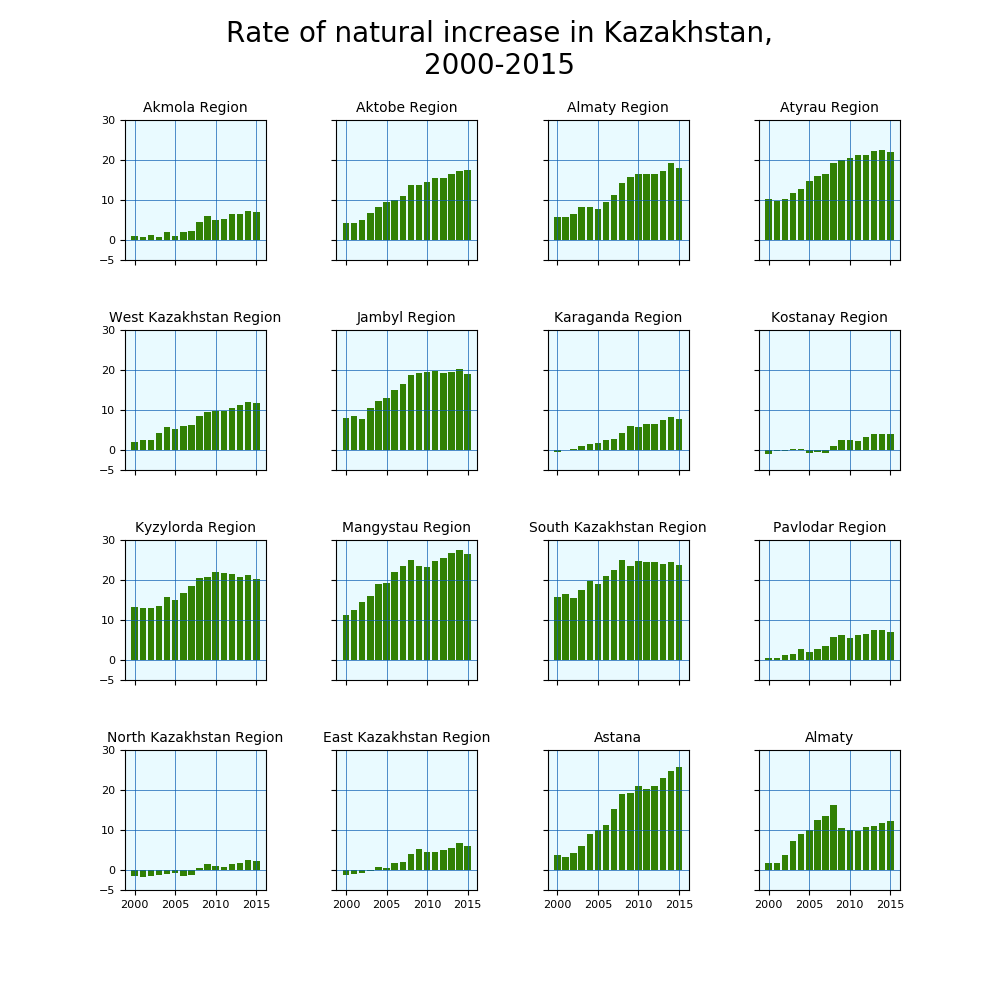

In [8]:
# BARCHARTS
# Creating figure's grid with gridspec

years = RNI.columns.values

fig = plt.figure(figsize=(10, 10))
gspec = gridspec.GridSpec(4, 4, wspace=0.5, hspace=0.5)

for i in range(4):
    for j in range(4):
        plt.subplot(gspec[i,j])
         
axes = fig.get_axes()
mpl.rcParams['axes.titlesize'] = 10

for i in range(16):
    axes[i].bar(years, RNI.iloc[i+1], color='#318004')
    axes[i].set_title(RNI.index.values[i+1])

for ax in axes:
    ax.set_facecolor('#E9FAFF')
    ax.set_yticks([-5, 0, 10, 20, 30])
    ax.set_xticks([2000, 2005, 2010, 2015])
    ax.xaxis.grid(b=False)
    ax.yaxis.grid(b=False)
    ax.yaxis.label.set_visible(False)
    ax.grid(axis='both', color='#0E60B3', linestyle='-', linewidth=0.5)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(8)    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(8)

# Removing excessive tick labels        
for i in range(16):
    if i != 0 and i % 4 != 0:
        plt.setp(axes[i].get_yticklabels(), visible=False)
    if i < 12:
        plt.setp(axes[i].get_xticklabels(), visible=False)
        
plt.suptitle('Rate of natural increase in Kazakhstan,\n2000-2015', fontsize=20)
#plt.savefig('RNI_kz')

In [9]:
GRAY = '#F5F5F5'
GREY = '#7E7E7E'
cmaps = [cm.PuBu, cm.hot_r, cm.BuGn]
DECOLOR = cmaps[0](0.9)
BGDECOLOR = cmaps[0](0.1)
plist = []

def draw_map(year, df=crude_birth_rate, colormap=cm.PuBu):
    remove_map()
    mmm = df.iloc[1:].max().max()-df.iloc[1:].min().min()    
    make_colorbar(year, df, colormap) 
    for shapeRec in shapeRecs:
        poly = shapeRec.shape.__geo_interface__
        region = shapeRec.record[4]
        color = colormap((df.loc[region, year]-df.iloc[1:].min().min())/mmm)
        # Draw region's polygon using descartes' PolygonPatch
        p = ax.add_patch(PolygonPatch(poly, picker=True, fc=color, ec=GREY, linewidth=1, alpha=0.75, zorder=2))
        p.set_label(region)
        plist.append(p)
        
    ax.axis('equal')
    title = swStates[str(radio.value_selected)][1]
    ax.set_title(title+'{}'.format(int(year)), fontsize=20)   
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor(GRAY)
    
    astn_color = colormap((df.loc['Astana', year]-df[year][1:].min())/mmm)
    almt_color = colormap((df.loc['Almaty', year]-df[year][1:].min())/mmm)
    c_astana = plt.Circle((82, 40), 0.5, facecolor=astn_color,
                    edgecolor=GREY, linewidth=1, fill=True, alpha=1)
    c_almaty = plt.Circle((82, 38.5), 0.5, facecolor=almt_color,
                    edgecolor=GREY, linewidth=1, fill=True, alpha=1)
    ax.add_artist(c_astana)
    ax.add_artist(c_almaty)
    
def remove_map():
    global plist
    if len(plist) > 0: 
        for patch in plist:
            patch.remove()
    plist = []

# Every time slider is moved, map is redrawn    
def update_slider(val):
    year_value=int(round(val))
    df = swStates[str(radio.value_selected)][0]
    colormap = swStates[str(radio.value_selected)][2]
    
    draw_map(year_value, df, colormap)

    amp_slider.vline.set_xdata(year_value)
    fig.canvas.draw_idle()

def make_colorbar(year, df, colormap=cm.PuBu):
    
    vmin = df.iloc[1:,].min().min()
    vmax = df.iloc[1:,].max().max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    ticks = [vmin, (vmax+vmin)/2, vmax]
    cb1 = mpl.colorbar.ColorbarBase(colorax, cmap=colormap,
                                norm=norm, ticks=ticks,
                                orientation='horizontal')
    ticks[1] = '%.0f' % ticks[1]
    cb1.ax.set_xticklabels(ticks)
    cb1.set_label('per 1000')
    return cb1

def switcher(val):
    year_value = int(round(amp_slider.val))
    ax.set_title('{} in Kazakhstan - {}'.format(val, year_value), fontsize=20)
    df = swStates[str(radio.value_selected)][0]
    colormap = swStates[str(radio.value_selected)][2]
    draw_map(year_value, df, colormap)
    make_colorbar(year_value, df, colormap)
    fig.canvas.draw_idle()

<IPython.core.display.Javascript object>


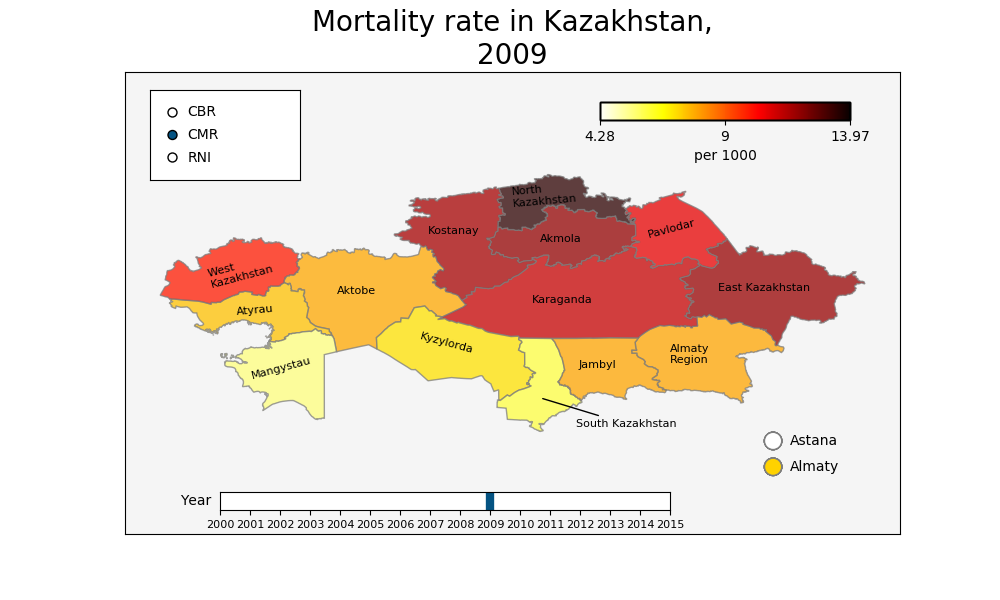

C:\Users\owlish\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [10]:
year = 2000
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()

# Creating years slider
amp_slider_ax = fig.add_axes([0.22, 0.15, 0.45, 0.03], axisbg='w')
amp_slider = widgets.Slider(amp_slider_ax, 'Year',
                            facecolor='w', edgecolor='w',
                            valmin=RNI.columns.values[0], 
                            valmax=RNI.columns.values[-1], 
                            valinit=year,
                            dragging=False)
amp_slider.vline.set_color(DECOLOR)
amp_slider.vline.set_linewidth(6)
amp_slider.ax.set_xticks(list(RNI.columns.values))
amp_slider.valtext.set_visible(False)
for tick in amp_slider.ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8) 

# Creating radiogroup which wsitches between crude birth rate, crude mortality rate and rate of natural increase
rax = plt.axes([0.15, 0.7, 0.15, 0.15], facecolor='w')
radio = widgets.RadioButtons(rax, ('CBR', 'CMR', 'RNI'), activecolor=DECOLOR)
radio.ax.set_picker(100)
for circle in radio.circles:
    circle.width = 0.06
    circle.height = 0.1


# Switcher dict for radiogroup
swStates = {'CBR': (crude_birth_rate, 'Birth rate in Kazakhstan,\n', cmaps[0]), 
            'CMR': (crude_mort_rate, 'Mortality rate in Kazakhstan,\n', cmaps[1]),
            'RNI': (RNI, 'Rate of natural increase in Kazakhstan,\n', cmaps[2])}

# Axes for colorbar
colorax = plt.axes([0.6, 0.80, 0.25, 0.03], facecolor=GRAY)

# On change of radiogroup and slider 
radio.on_clicked(switcher)    
amp_slider.on_changed(update_slider) 

# Initial map draw, dataframe is crude_birth_rate
initial_df = swStates[str(radio.value_selected)][0]
draw_map(year, initial_df)    

# Adding text to circles
ax.text(83, 39.75, 'Astana')
ax.text(83, 38.25, 'Almaty')

# Adding names of regions to map 
ax.annotate('West\nKazakhstan', xy=(49.2, 49), xytext=(49.2, 49.8), size=8, rotation=15)
ax.annotate('Atyrau', xy=(50.9, 47.5), xytext=(50.9, 47.5), size=8, rotation=5)
ax.annotate('Mangystau', xy=(51.7, 44.5), xytext=(51.7, 44.5), size=8, rotation=15)
ax.annotate('Aktobe', xy=(56.7, 48.5), xytext=(56.7, 48.5), size=8)
ax.annotate('Kostanay', xy=(62, 52), xytext=(62, 52), size=8)
ax.annotate('North\nKazakhstan', xy=(66.8, 53.9), xytext=(66.8, 53.9), size=8, rotation=5)
ax.annotate('Akmola', xy=(68.5, 51.5), xytext=(68.5, 51.5), size=8)
ax.annotate('Pavlodar', xy=(74.7, 52.5), xytext=(74.7, 52.5), size=8, rotation=15)
ax.annotate('Karaganda', xy=(68, 48), xytext=(68, 48), size=8)
ax.annotate('Kyzylorda', xy=(61.3, 45.7), xytext=(61.5, 45.9), size=8, rotation=-15)
ax.annotate('Jambyl', xy=(70.7, 44.2), xytext=(70.7, 44.2), size=8)
ax.annotate('Almaty\nRegion', xy=(76, 44.5), xytext=(76, 44.5), size=8)
ax.annotate('East Kazakhstan', xy=(78.8, 48.7), xytext=(78.8, 48.7), size=8)
ax.annotate('South Kazakhstan', xy=(68.5, 42.5), xytext=(70.6, 40.8), size=8, arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3"))

#a = animation.FuncAnimation(fig, draw_map, frames=RNI.columns.values, interval=500)
plt.show()